# Backend : iteraction with user

In [29]:
# import
import os
import folium
import pyproj
from functools import partial
import pandas as pd
from shapely.ops import transform
import geopandas as gpd
import openrouteservice as ors
from IPython.display import display
from shapely.geometry import Point, LineString, Polygon

### User input coordinates : addresses later.

In [2]:
# input coordinates
coordinates = [[2.3668617010116577,48.86100925394748 ], [2.4125343561172485, 48.83392954811057]]

In [3]:
# openrouteservices 
client = ors.Client(key='5b3ce3597851110001cf62485169f9e2d05c419eaf0607fe2b5b0bfa')

#requete openrouteservice
route = client.directions(
    coordinates=coordinates,
    profile='cycling-regular',
    format ='geojson',
    units ='km'
)

,cluster_index,geometry
45,45,"POLYGON ((2.36170 48.83985, 2.36174 48.83999, ..."
100,100,"POLYGON ((2.29236 48.83907, 2.29146 48.83913, ..."


/Users/mac/Desktop/2R/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/mac/Desktop/2R/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


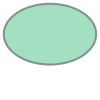

In [31]:
# get clusters
cluster_polygons_file = "../model/model_cluster/cluster_polygons.geojson"
gdf_cluster = gpd.read_file(cluster_polygons_file)

display(gdf_cluster.sample(2))

# buffer on cluster data
buffer_in_meters(2.31, 48.86, 1)

In [5]:
# user route to df
user_line_df = pd.DataFrame(route['features'][0]['geometry']['coordinates'],
                            columns=["lon", "lat"])

# df to gdf
user_line_gdf = gpd.GeoDataFrame(user_line_df, 
                    geometry=gpd.points_from_xy(user_line_df.lon, user_line_df.lat),
                    crs="epsg:4326")

display(user_line_gdf.sample(2))

,lon,lat,geometry
127,2.398968,48.841036,POINT (2.39897 48.84104)
57,2.380408,48.857554,POINT (2.38041 48.85755)


In [21]:
#!pip install rtree
#!pip install pygeos

In [22]:
# intersect : spatial join
cluster_on_route = gpd.sjoin(gdf_cluster, user_line_gdf)[gdf_cluster.columns]

In [10]:
cluster_on_route

,cluster_index,geometry
18,18,"POLYGON ((2.40658 48.83535, 2.40694 48.83559, ..."


In [19]:
# localisation Paris
m = folium.Map(location=[48.862, 2.346], tiles='cartodbpositron', zoom_start=12)

# add user itinerary polyline
folium.PolyLine(locations=[list(reversed(coord)) 
                           for coord in 
                           route['features'][0]['geometry']['coordinates']]).add_to(m)

# cluster on map
gdf = cluster_on_route
for _, r in gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#ff0000'})
    folium.Popup(r['cluster_index']).add_to(geo_j)
    geo_j.add_to(m)

In [20]:
m

In [ ]:
# export map
m.save("./templates/map.html")